In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter("ignore", category=FutureWarning)

In [2]:
#Import all necessary libraries
import glob
import pandas as pd
import numpy as np

from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore

import fastparquet
import pyLDAvis
import pyLDAvis.gensim
import warnings
import _pickle as pickle

import re
import random
import collections
import seaborn as sns

from gensim import corpora, models
import gensim
import pyLDAvis.gensim

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from scipy import stats

pyLDAvis.enable_notebook()
random.seed(1234)

from sklearn.metrics.cluster import adjusted_rand_score
pd.options.display.max_columns = None

# 1. Topic Model on CommonCrawl


## 1.1. Loading and Filtering the Data
There are 28 files with ~2500 records each. 

In [ ]:
%%time
#Load the parquet files into a single dataframe

result = pd.DataFrame()
#for filename in os.listdir("C:\\tmp\\my.tar\\istjoscha_cc_warc_wat_wet_acht_lang"):
for pth in sorted(glob.glob("data/CC/*")):
    ds = pd.read_parquet(pth)
    #print(pth)
    #print(ds.shape)
    result = result.append(ds)
    #print(result.shape)

#In case you are running out of memory, try to run the filter in the following paragraph on ds before appending

In [4]:
#filter on English and university-related content
result = result.loc[(result['Guessed-Language']=='en') & (result['Plaintext'].str.contains("niversity"))]

## 1.2 Constructing the Corpus and Building the Model

In [5]:
#auxiliary function for "straight-forward" natural language preprocessing

def cleanup_text(record):
    text = record['Plaintext']
    # Remove newlines
    text = text.replace(r'\n', ' ')
    words = text.split()

    # Default list of Stopwords
    stopwords_core = ['a', u'about', u'above', u'after', u'again', u'against', u'all', u'am', u'an', u'and', u'any',
                      u'are', u'arent', u'as', u'at',
                      u'be', u'because', u'been', u'before', u'being', u'below', u'between', u'both', u'but', u'by',
                      u'can', 'cant', 'come', u'could', 'couldnt',
                      u'd', u'did', u'didn', u'do', u'does', u'doesnt', u'doing', u'dont', u'down', u'during',
                      u'each',
                      u'few', 'finally', u'for', u'from', u'further',
                      u'had', u'hadnt', u'has', u'hasnt', u'have', u'havent', u'having', u'he', u'her', u'here',
                      u'hers', u'herself', u'him', u'himself', u'his', u'how',
                      u'i', u'if', u'in', u'into', u'is', u'isnt', u'it', u'its', u'itself',
                      u'just',
                      u'll',
                      u'm', u'me', u'might', u'more', u'most', u'must', u'my', u'myself',
                      u'no', u'nor', u'not', u'now',
                      u'o', u'of', u'off', u'on', u'once', u'only', u'or', u'other', u'our', u'ours', u'ourselves',
                      u'out', u'over', u'own',
                      u'r', u're',
                      u's', 'said', u'same', u'she', u'should', u'shouldnt', u'so', u'some', u'such',
                      u't', u'than', u'that', 'thats', u'the', u'their', u'theirs', u'them', u'themselves', u'then',
                      u'there', u'these', u'they', u'this', u'those', u'through', u'to', u'too',
                      u'under', u'until', u'up',
                      u'very',
                      u'was', u'wasnt', u'we', u'were', u'werent', u'what', u'when', u'where', u'which', u'while',
                      u'who', u'whom', u'why', u'will', u'with', u'wont', u'would',
                      u'y', u'you', u'your', u'yours', u'yourself', u'yourselves']

    # Custom List of Stopwords - Add your own here
    stopwords_custom = ['']
    stopwords = stopwords_core + stopwords_custom
    stopwords = [word.lower() for word in stopwords]

    text_out = [re.sub('[^a-zA-Z0-9]', '', word) for word in words]  # Remove special characters
    text_out = [word.lower() for word in text_out if
                len(word) > 2 and word.lower() not in stopwords]  # Remove stopwords and words under X length
    return text_out


In [ ]:
%%time
#build gensim corpus

result=result.reset_index()
texts=[]
for index, row in result.iterrows():
    texts.append(cleanup_text(row))

dictionary = corpora.Dictionary(texts)   # Create a dictionary representation of the documents.
dictionary.filter_extremes(no_below=10, no_above=0.4)   # Filter out words that occur less than 10 documents and more than 40% of the documents.
dictionary.compactify()   # assign new word ids to all words.
corpus = [dictionary.doc2bow(text) for text in texts] # Bag-of-words representation of the documents

In [ ]:
dictionary[1000]   # example output

In [ ]:
corpus   # word-id, frequency of the word

In [ ]:
%%time
ldamodelnormal = gensim.models.ldamodel.LdaModel(corpus, num_topics=15, id2word = dictionary, passes=10, chunksize=100, update_every=0, alpha=1/15, random_state=1)
# hyperparameter: 
# corpus: word-id, frequency of the word
# num_topics: number of topics
# id2word: representation of the documents
# passes: how many times the algorithm is supposed to pass over the whole corpus
# chunksize: number of documents to consider at once (affects the memory consumption)
# update_every: update the model every chunks
# alpha: smoothing parameter

## 1.3 Inspecting the Results

In [10]:
# helper to create descriptive tables (doc-topic probabilities) and visualizations for LDA models 
def getModelResults(ldamodel, corpus, dictionary):
    vis = pyLDAvis.gensim.prepare(ldamodel,corpus, dictionary, sort_topics=False)
    transformed = ldamodel.get_document_topics(corpus)
    df = pd.DataFrame.from_records([{v:k for v, k in row} for row in transformed])
    return vis, df    

In [11]:
# get the top topic per document into a list
def maxTop(x):
    mx = max(x,key=lambda item:item[1])
    if (mx[1]>0.0):
        return(mx[0])
    else:
        return 99

In [ ]:
%%time
# get descriptive stuff for all models
normalv, dfnormal = getModelResults(ldamodelnormal, corpus, dictionary)

In [ ]:
#print regular topics (top word probabilities)
ldamodelnormal.print_topics(num_words=8)

---

# <span style="color:green">Teil 1</span>
## <span style="color:green">Aufgabe 1: Schauen Sie sich die Topic-Wortverteilungen des erstellten Modells an (in Textform, der interaktiven Ausgabe, oder als Wordcloud). Für welche Topics können Sie intuitiv Überbegriffe bilden? Notieren Sie sich diese bzw. legen Sie eine entsprechende „lookup-tabelle“ als Datenstruktur an. Welche Topics erscheinen sinnvoll, welche nicht?</span>

In [14]:
topics = {
    0: 'Research', 
    1: 'Misc',
    2: 'Month',
    3: 'Life',
    4: 'Education', 
    5: 'Misc',
    6: 'Architecture', 
    7: 'Adult', 
    8: 'Country', 
    9: 'Misc', 
    10: 'Month', 
    11: 'Technology',
    12: 'Misc',
    13: 'Government',
    14: 'Climate'
}

---

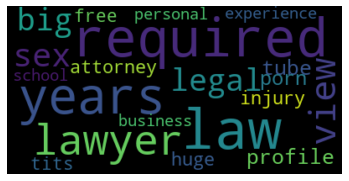

Adult Topic Id = 7


In [15]:
# create a wordcloud for topic: adult content

# get the top topic for a known adult content document 
docTopTopics = [maxTop(x) for x in ldamodelnormal.get_document_topics(corpus)]
adultTopicId = docTopTopics[15]

#gather most relevant terms for the given topic
topics_terms = ldamodelnormal.state.get_lambda()
tmpDict = {}
for i in range(1, len(topics_terms[0])):
    tmpDict[ldamodelnormal.id2word[i]]=topics_terms[adultTopicId,i]

# draw the wordcloud
wordcloud = WordCloud( margin=0,max_words=20 ).generate_from_frequencies(tmpDict)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()
print("Adult Topic Id = " + str(adultTopicId))

In [16]:
# inspect regular topics - ATTENTION: ALL TOPICS ARE SHIFTED WITH ID +1 w.r.t. GENSIM
normalv

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.022398  0.057067       1        1   4.093208
1     -0.062898 -0.003101       2        1   8.271789
2      0.038283 -0.027314       3        1   7.652359
3      0.037484 -0.035702       4        1  13.628202
4      0.083631  0.021533       5        1   8.952338
5     -0.014266  0.005649       6        1   2.926609
6      0.010160 -0.040610       7        1   3.928503
7      0.024614 -0.022245       8        1   3.311718
8      0.034279 -0.025834       9        1   4.041581
9     -0.153347 -0.015513      10        1  14.698672
10     0.024196  0.086517      11        1   5.715767
11    -0.087725 -0.018147      12        1   4.187424
12     0.057951 -0.059305      13        1   5.664464
13     0.017450 -0.000846      14        1  10.992838
14     0.012587  0.077852      15        1   1.934537, topic_info=      Category         Freq        Term        Total  loglift  logprob
11676  Default  5185.000000  architects  5185.000000  30.0000  30.0000
10371  Default  3828.000000        temp  3828.000000  29.0000  29.0000
9200   Default  2300.000000         max  2300.000000  28.0000  28.0000
528    Default  2281.000000         min  2281.000000  27.0000  27.0000
281    Default  6012.000000    download  6012.000000  26.0000  26.0000
...        ...          ...         ...          ...      ...      ...
1526   Topic15   159.030579        care  3200.542480   0.9433  -5.9732
1209   Topic15   102.816711       floor   500.858612   2.3619  -6.4093
1792   Topic15   111.775703     million  1085.342773   1.6721  -6.3258
875    Topic15   122.748451        view  4462.501953   0.3520  -6.2322
849    Topic15   114.761383         two  4218.251953   0.3410  -6.2994

[1153 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
12427      1  0.010907   039
12427      2  0.643525   039
12427      3  0.010907   039
12427      4  0.032722   039
12427      5  0.010907   039
...      ...       ...   ...
2044      11  0.030291  york
2044      12  0.012039  york
2044      13  0.067183  york
2044      14  0.055922  york
2044      15  0.020194  york

[12165 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

In [ ]:
#inspect first 20 documents and their topic distributions
pd.set_option('display.max_colwidth', -1)
pd.concat([result['Target-URI'], dfnormal], axis=1).iloc[0:20]

---

# <span style="color:green">Teil 1</span>
## <span style="color:green">Aufgabe 2: Notieren Sie sich, welches Topic in Codeblock 11 als „adult content“ identifiziert wurde. Filtern Sie für die weiteren Aufgaben die entsprechenden Records aus dem „result“ DataFrame aus, also z.B. alle Dokumente mit einer entsprechenden Topicwahrscheinlichkeit > 50%. Öffnen Sie nicht die Links zu den entsprechenden Dokumenten im Browser. Aktivieren Sie sicherheitshalber den installierten Browser-Filter.</span>

In [18]:
dfnormal = dfnormal.sort_index(axis=1)
result_new = pd.concat([result['Target-URI'], dfnormal], axis=1)
result_new_with_adult = result_new[result_new[7] > 0.5]

In [ ]:
# remove adult content > 0.5
result_new = pd.concat([result_new, result_new_with_adult]).drop_duplicates(keep=False)
result_new.info()

In [ ]:
result_new_with_adult.info()

## <span style="color:green">Aufgabe 3: Schauen Sie sich nun für einige andere Topics stichprobenartig Dokumente an. Passen diese zu den vorher von Ihnen vergebenen Topic-Überbegriffen? Warum bzw. warum nicht?</span>

In [21]:
def print_topics(topic_id, topic_prob):
    print("Topic #" + str(topic_id) + ": " + topics[topic_id])
    display(result_new[result_new[topic_id] > topic_prob][:5])

In [ ]:
for i in range(len(topics)):
    if (i != 7):
        print_topics(i, 0.5)

## <span style="color:green">Aufgabe 4: Formulieren Sie Anfragen zu bestimmten Topic-Mischungen (z.B. Topic A > 40% und Topic B > 40%). Passen die gematchten Dokumente zu Ihren Erwartungen? Warum bzw. warum nicht?</span>

In [ ]:
print(topics[0], " AND ", topics[4])
result_new[(result_new[0] > 0.4) &  (result_new[4] > 0.4)][:5]

In [ ]:
print(topics[6], " AND ", topics[11])
result_new[(result_new[6] > 0.4) &  (result_new[11] > 0.4)][:5]

## <span style="color:green">Aufgabe 5: Berechnen Sie zwei neue Modelle (auf dem Original-Corpus mit Adult-Content) mit verändertem Glättungsparameter für die Dokument-Topic Zuordnungen. Die restlichen Parameter sollen beibehalten werden. Berechnen Sie ein Modell mit Glättungsparameter=1 und ein Modell mit Glättungsparameter=10^-18. Schauen Sie sich wieder jeweils die ersten 20 Zeilen der Dokument-Topic Wahrscheinlichkeitsmatrizen an. Plotten Sie weiterhin die Häufigkeitsverteilungen der „Nicht-NaN-Topics“ pro Dokument.</span>

In [25]:
def plot_notna_values(df_notna, alpha):
    df_notna= df_notna.notna().sum() 
    df_notna = pd.DataFrame(df_notna)
    df_notna.reset_index(inplace=True)
    df_notna.columns = ["topic", "number"]
    sns.set(rc={'figure.figsize':(20,7)})
    ax = sns.barplot(x="topic", y="number",data=df_notna).set_title('notna-frequency')
    #fig = ax.get_figure()
    #fig.savefig('plots/barplot_alpha_' + alpha + '.png')

### <span style="color:green">Glättungsparameter (alpha) = 1</span>

In [26]:
ldamodelnormal_1 = gensim.models.ldamodel.LdaModel(corpus, num_topics=15, id2word = dictionary, passes=10, chunksize=100, update_every=0, alpha=1, random_state=1)
normalv_1, dfnormal_1 = getModelResults(ldamodelnormal_1, corpus, dictionary)

In [ ]:
dfnormal_1 = dfnormal_1.sort_index(axis=1)
dfnormal_1.head(20)

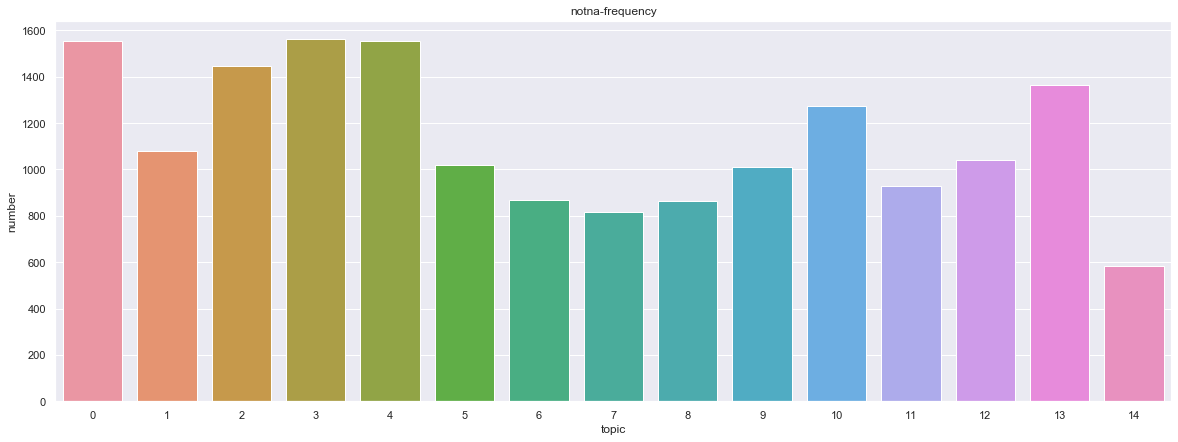

In [28]:
plot_notna_values(dfnormal_1, '1')

### <span style="color:green">Glättungsparameter (alpha) = 10<sup>-18</sup></span>

In [29]:
ldamodelnormal_1_18 = gensim.models.ldamodel.LdaModel(corpus, num_topics=15, id2word = dictionary, passes=10, chunksize=100, update_every=0, alpha=10**(-18), random_state=1)
normalv_1_18, dfnormal_1_18 = getModelResults(ldamodelnormal_1_18, corpus, dictionary)

In [ ]:
dfnormal_1_18 = dfnormal_1_18.sort_index(axis=1)
dfnormal_1_18.head(20)

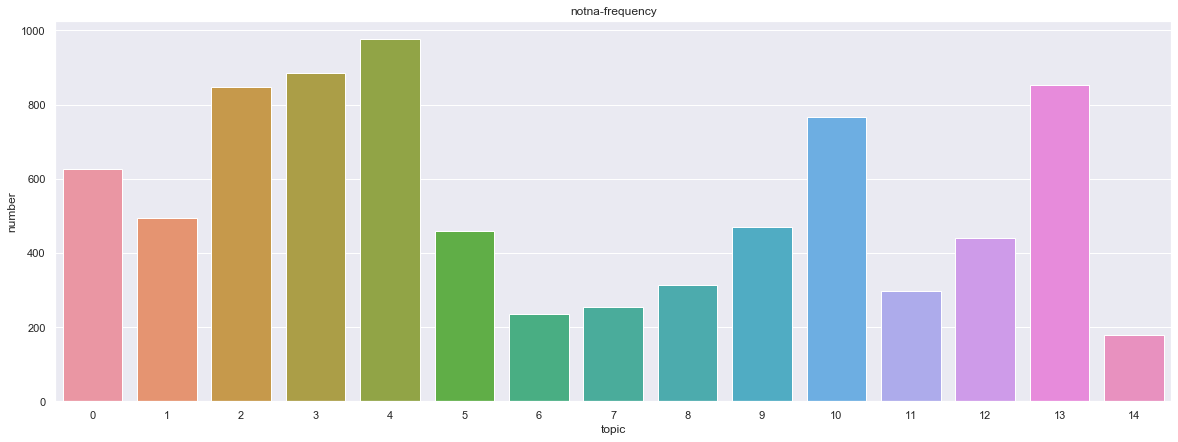

In [31]:
plot_notna_values(dfnormal_1_18, '10_-18')

---

# 2. Topic Model on NHTSA (Using HANA Text Analysis Index Table)
## 2.1  Constructing the Corpus (Using HANA Text Analysis Index Table) and Building the Model

In [32]:
#data ingestion and filtering

cmpl = pd.read_csv("data/NHTSA_HANA/cmpl.csv", header=None,  keep_default_na=False)
ta = pd.read_csv("data/NHTSA_HANA/data.csv", header=None,  keep_default_na=False)

ta.columns = ["CMPLID", "TA_RULE","TA_COUNTER","TA_TOKEN","TA_LANGUAGE","TA_TYPE","TA_TYPE_EXPANDED",
              "TA_NORMALIZED" ,"TA_STEM","TA_PARAGRAPH","TA_SENTENCE","TA_CREATED_AT","TA_OFFSET","TA_PARENT" ]
cmpl.columns = ["CMPLID", "ODINO", "MFR_NAME", "MAKETEXT", "MODELTXT", "YEARTXT", "CRASH", "FAILDATE", "FIRE", "INJURED", "DEATHS", "COMPDESC", "CITY", "STATE", "VIN", "DATEA", "LDATE", "MILES", "OCCURRENCES", "CDESCR", "CMPL_TYPE", "POLICE_RPT_VN", "PURCH_DT", "ORIG_OWNER_YN", "ANTI_BRAKES_YN", "CRUISE_CONT_YN", "NUM_CYLS", "DRIVE_TRAIN", "FUEL_SYS", "FUEL_TYPE", "TRANS_TYPE", "VEH_SPEED", "DOT", "TIRE_SIZE", "LOC_OF_TIRE", "TIRE_FAIL_TYPE", "ORIG_EQUIP_YN", "MANUF_DT", "SEAT_TYPE", "RESTRAINT_TYPE", "DEALER_NAME", "DEALER_TEL", "DEALER_CITY", "DEALER_STATE", "DEALER_ZIP", "PROD_TYPE", "REPAIRED_YN", "MEDICAL_ATTN", "VEHICELS_TOWED_YN"]


In [33]:
#filtering and aggregation

ta = ta[ta.TA_TYPE.isin(['noun', 'adjective']) ]
ta.TA_TOKEN = ta.TA_TOKEN.str.lower()
ta = ta[~ta.TA_TOKEN.isin(['car', 'vehicle']) ] #use as additional stop words
cmpl = cmpl[cmpl.COMPDESC.isin([ 'AIR BAGS','VISIBILITY/WIPER','EXTERIOR LIGHTING','FUEL/PROPULSION SYSTEM', 'SERVICE BRAKES','WHEELS']) ]

ta = ta.merge(cmpl.loc[:,'CMPLID'], on=['CMPLID'], how='inner')
tagrouped = ta.groupby('CMPLID')['TA_TOKEN'].apply(list)

In [ ]:
#show category counts
relevantComplaints = cmpl[cmpl.CMPLID.isin(tagrouped.index.tolist())].sort_values(by=['CMPLID'])
counter=collections.Counter(relevantComplaints.COMPDESC)
print(counter)
print("Anzahl Dokumente: " + str(len(relevantComplaints)))

In [35]:
#create gensim data structure
nhtsadic = corpora.Dictionary(tagrouped.tolist())
nhtsadic.filter_extremes(no_below=10, no_above=0.4)
nhtsadic.compactify()
nhtsacorpus = [nhtsadic.doc2bow(text) for text in tagrouped]

In [ ]:
%%time

#build topic model and create descriptive stuff
nhtsalda = LdaMulticore(nhtsacorpus, num_topics=10, id2word = nhtsadic, passes=20, alpha=0.0000001, random_state=1)
nhtsavis, dfnhtsa = getModelResults(nhtsalda, nhtsacorpus, nhtsadic)

## 2.2 Inspecting the Results

In [37]:
nhtsavis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.124534 -0.136048  1       1        9.418113 
1      0.000515 -0.005236  2       1        7.974082 
2      0.031858  0.122700  3       1        7.858271 
3     -0.000051 -0.025691  4       1        12.837943
4      0.052765  0.020296  5       1        6.272823 
5      0.056114  0.119336  6       1        15.503510
6      0.001231  0.137167  7       1        5.873322 
7     -0.002479 -0.095050  8       1        12.540590
8      0.078816 -0.100285  9       1        8.144452 
9     -0.343303 -0.037189  10      1        13.576894, topic_info=    Category         Freq        Term        Total  loglift  logprob
780  Default  4722.000000  contact     4722.000000  30.0000  30.0000
27   Default  4133.000000  failure     4133.000000  29.0000  29.0000
241  Default  4390.000000  brake       4390.000000  28.0000  28.0000
597  Default  1589.000000  windshield  1589.000000  27.0000  27.0000
51   Default  3061.000000  brakes      3061.000000  26.0000  26.0000
..       ...          ...     ...              ...      ...      ...
241  Topic10  390.638062   brake       4390.533203 -0.4226  -4.6567 
111  Topic10  322.832123   front       2683.631104 -0.1210  -4.8474 
25   Topic10  295.899078   passenger   1847.151489  0.1654  -4.9345 
54   Topic10  264.460693   warning     952.987549   0.7149  -5.0468 
132  Topic10  271.962860   time        2743.520752 -0.3145  -5.0189 

[693 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1272  4      0.035336  01     
1272  10     0.918728  01     
1796  8      0.036611  03     
1796  10     0.951876  03     
1273  10     0.961205  04     
...   ..          ...  ..     
297   7      0.113011  year   
297   8      0.151354  year   
297   9      0.092831  year   
297   10     0.002018  year   
1880  9      0.974271  youtube

[2699 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

---

# <span style="color:green">Teil 2</span>
## <span style="color:green">Aufgabe 1: Machen Sie sich, ähnlich wie in Teil I, mit dem erstellten Topicmodell für den NHTSA-Teildatensatz vertraut, indem Sie einzelne Topics bzw. Dokumente genauer unter die Lupe nehmen. Dokumentieren Sie Ihre Erkenntnisse, d.h. in welchen Fällen Sie das Modell für sinnvoll halten und in welchen nicht.</span>

In [38]:
topics = {
    0: 'Lighting',
    1: 'Wheels',
    2: 'Brakes',
    3: 'Air Bags',
    4: 'Trailer', 
    5: 'Engine',
    6: 'Fuel',
    7: 'Tire',
    8: 'Windshield', 
    9: 'Contact'
}

In [ ]:
nhtsalda.print_topics(num_words=8)

## <span style="color:green">Aufgabe 2: Überführen Sie das Soft-Clustering in ein Hard-Clustering, indem Sie einen Vektor erstellen, der pro Dokument das Topic mit der höchsten Wahrscheinlichkeit enthält. Die NHTSA-Kategorien (COMPDESCR) finden Sie bereits im Vektor docCats. Berechnen Sie auf dieser Basis die RANDMetrik zum Vergleich von Clusterings und interpretieren Sie diese soweit möglich.</span>

In [ ]:
dfnhtsa = dfnhtsa.sort_index(axis=1)
dfnhtsa.head(20)

In [ ]:
import numpy as np
best_topic_document = []

for i in range(0, dfnhtsa.shape[0], 1):
    topic_p = dfnhtsa.to_numpy()[i].tolist()
    max_value = np.nanmax(topic_p)
    max_index = topic_p.index(max_value)
    
    best_topic_document.append((i,max_index,max_value) )
    
max_p_df = pd.DataFrame(best_topic_document, columns=['Document', 'Topic', 'Probability (P)'])
max_p_df.head(10)

### RAND-Metrik
$Accuracy = \frac{TP + TN}{TP+FP+FN+TN}$

In [42]:
docCats = relevantComplaints['COMPDESC'].tolist()

In [43]:
def calculate_accuracy_numpy(df):
    df_topic = df['Topic']
    df_doc = df['Document']
    numpy_array_topic = df_topic.to_numpy()
    numpy_array_doc = df_doc.to_numpy()
    
    TP = 0
    TN = 0
    FN = 0
    FP = 0
    
    for t, d in np.nditer([numpy_array_topic, numpy_array_doc]):
        for t2, d2 in np.nditer([numpy_array_topic, numpy_array_doc]):
            c1 = docCats[int(d)]
            c2 = docCats[int(d2)]
            t1 = t
            t2 = t2

            if(c1 == c2):
                if(t1 == t2):
                    TP = TP + 1

                if(t1 != t2):
                    FP = FP + 1
            else:
                if(t1 == t2):
                    FN = FN + 1

                if(t1 != t2):
                    TN = TN + 1

    accuracy = (TP + TN) / (TP+FP+FN+TN)
    print(accuracy)

In [ ]:
max_p_df.info()

In [45]:
calculate_accuracy_numpy(max_p_df)

0.779259677993457


## <span style="color:green">Aufgabe 3: Erstellen Sie eine Kreuztabellle, bei der eine Dimension die Topics und eine Dimension die Kategorien (COMPDESC) darstellen. In den Zellen soll gezählt werden, wie häufig im Corpus das Top-Topic eines Dokuments mit der tatsächlichen Kategorie korrespondiert. Nutzen Sie zur Visualisierung z.B. „clustermap“ aus der Python Bibliothek seaborn. Wie interpretieren Sie die Ergebnisse? Schauen Sie sich einzelne Dokumente als Repräsentanten/Beispiele interessanter Konstellationen in der Kreuztabelle an.</span>

In [46]:
docCats_df = pd.DataFrame(docCats)
docCats_df.columns = ['Cat']
docCats_df_new = docCats_df.reset_index()

In [47]:
max_p_df_new = max_p_df.reset_index()
df_new = pd.merge(docCats_df_new, max_p_df_new, on='index')
df_new
df = df_new[['Cat', 'Document', 'Topic']]
df.insert(3,'New',1)
pivot_df = df.pivot_table(values='New', index='Cat', columns='Topic', aggfunc=np.sum)
pivot_df

Topic,0,1,2,3,4,5,6,7,8,9
Cat,,,,,,,,,,
AIR BAGS,11,210,53,590,63,94,37,788,62,730
EXTERIOR LIGHTING,748,38,15,92,207,38,26,24,26,109
FUEL/PROPULSION SYSTEM,14,76,42,348,29,727,317,26,31,178
SERVICE BRAKES,54,165,630,231,263,755,171,85,67,511
VISIBILITY/WIPER,239,18,10,47,21,19,10,116,584,111
WHEELS,20,269,31,100,6,43,21,561,13,93


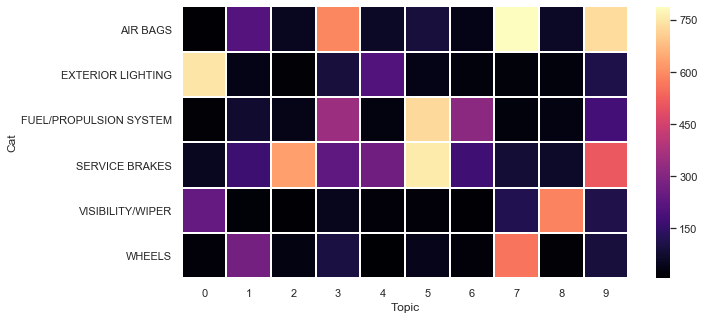

In [48]:
sns.set(rc={'figure.figsize':(10,5)})
ax = sns.heatmap(pivot_df, cmap='magma', linecolor='white', linewidth=1)
#fig = ax.get_figure()
#fig.savefig('plots/heatmap_nhtsa.png')

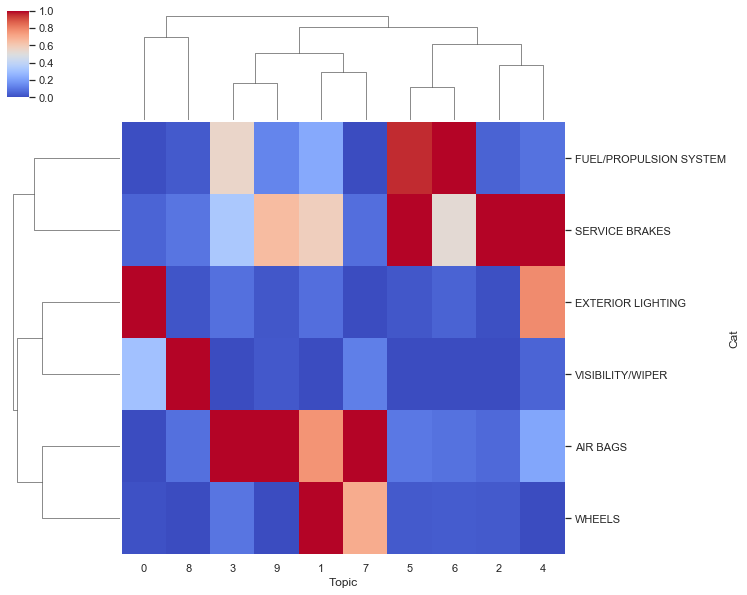

In [49]:
sns.clustermap(pivot_df, cmap='coolwarm', standard_scale=1)
#plt.savefig('plots/clustermap_nhtsa.png')

---

# <span style="color:green">Teil 3 - t3n Daten</span>
## <span style="color:green">Erstellen Sie ein bzw. ggf. mehrere Topicmodelle und übertragen Sie die Schritte bzw. Fragenstellungen aus Teil I und II soweit wie möglich. Dokumentieren Sie die Erkenntnisse etwas ausführlicher. Begründen Sie ausreichend, an welchen Stellen eine direkte Übertragung ggf. nicht möglich ist.</span>

### <span style="color:green">gensim</span>

In [50]:
#data ingestion and filtering
t3n = pd.read_csv("data/t3n/T3N.csv", keep_default_na=False)
ta_t3n = pd.read_csv("data/t3n/T3NTEXTIND.csv", keep_default_na=False)

In [ ]:
t3n

In [ ]:
ta_t3n.head()

In [ ]:
t3n['CATEGORY'].unique()

In [ ]:
# New function 
import nltk as nltk
from nltk.corpus import stopwords

def remove_stopwords(data):
    nltk.download('stopwords')
    german_stopwords = set(stopwords.words('german'))
    data['TA_TOKEN'] = data['TA_TOKEN'].str.lower() 
    #display(data)
    for index, row in data.iterrows():
        if row.TA_TOKEN in german_stopwords:
            data.drop(index, inplace=True)
    display(data)
    return data

In [ ]:
#filtering and aggregation

ta_t3n = ta_t3n[ta_t3n.TA_TYPE.isin(['noun', 'adjective']) ]
ta_t3n.TA_TOKEN = ta_t3n.TA_TOKEN.str.lower()

# remove stopwords
ta_t3n = remove_stopwords(ta_t3n)
#ta_t3n = ta_t3n[~ta_t3n.TA_TOKEN.isin(['car', 'vehicle']) ] #use as additional stop words
t3n = t3n[t3n.CATEGORY.isin([ 'Mobilität', 'E-Commerce', 'Digitale Wirtschaft',
       'Gadgets & Lifestyle', 'Marketing', 'Software & Infrastruktur',
       'Digitale Gesellschaft', 'Entwicklung & Design', 'Startups',
       'Karriere']) ]

ta_t3n = ta_t3n.merge(t3n.loc[:,'ID'], on=['ID'], how='inner')
tagrouped = ta_t3n.groupby('ID')['TA_TOKEN'].apply(list)

In [ ]:
ta_t3n

In [ ]:
#show category counts
relevantT3n = t3n[t3n.ID.isin(tagrouped.index.tolist())].sort_values(by=['ID'])
counter=collections.Counter(relevantT3n.CATEGORY)
print(counter)
print("Anzahl Dokumente: " + str(len(relevantT3n)))

In [58]:
#create gensim data structure
t3ndic = corpora.Dictionary(tagrouped.tolist())
t3ndic.filter_extremes(no_below=10, no_above=0.4)
t3ndic.compactify()
t3ncorpus = [t3ndic.doc2bow(text) for text in tagrouped]

In [ ]:
%%time

#build topic model and create descriptive stuff
t3nlda = LdaMulticore(t3ncorpus, num_topics=10, id2word = t3ndic, passes=20, alpha=0.0000001, random_state=1)
t3nvis, dft3n = getModelResults(t3nlda, t3ncorpus, t3ndic)

In [ ]:
t3nlda.print_topics(num_words=8)

In [61]:
t3nvis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.103258  0.181620  1       1        13.503059
1      0.107302  0.056037  2       1        8.560468 
2     -0.086184 -0.047564  3       1        7.393997 
3      0.032727 -0.068587  4       1        5.261013 
4     -0.012212  0.072821  5       1        8.069995 
5     -0.059605 -0.238155  6       1        14.319327
6      0.220853  0.003350  7       1        16.357145
7     -0.056148  0.049160  8       1        6.147265 
8      0.161773 -0.005944  9       1        4.099061 
9     -0.205247 -0.002739  10      1        16.288671, topic_info=    Category         Freq       Term        Total  loglift  logprob
280  Default  1413.000000  google     1413.000000  30.0000  30.0000
441  Default  1242.000000  apple      1242.000000  29.0000  29.0000
242  Default  611.000000   windows    611.000000   28.0000  28.0000
438  Default  555.000000   amazon     555.000000   27.0000  27.0000
425  Default  497.000000   microsoft  497.000000   26.0000  26.0000
..       ...         ...         ...         ...       ...      ...
11   Topic10  88.922173    com        209.038513   0.9599  -5.3747 
373  Topic10  135.120636   nutzer     706.203125   0.1610  -4.9562 
720  Topic10  76.836563    tools      150.344269   1.1435  -5.5207 
361  Topic10  99.381691    design     388.818085   0.4506  -5.2634 
448  Topic10  81.481171    bereich    190.369995   0.9661  -5.4620 

[608 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
51    5      0.799945  10   
51    7      0.068080  10   
51    9      0.119141  10   
51    10     0.008510  10   
53    3      0.040009  13   
...   ..          ...  ..   
1851  7      0.137785  zwei 
1851  8      0.027557  zwei 
1851  9      0.055114  zwei 
1851  10     0.771595  zwei 
1481  7      0.953224  zwölf

[2187 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

#### <span style="color:green">Lookup Table t3n</span>

In [62]:
topics = {
    0: 'Software & Infrastruktur', 
    1: 'Startups',
    2: 'E-Commerce',
    3: 'Digitale Wirtschaft',
    4: 'Entwicklung & Design', 
    5: 'Mobilität',
    6: 'Gadgets & Lifestyle', 
    7: 'Karriere', 
    8: 'Digitale Gesellschaft', 
    9: 'Marketing'
}

In [ ]:
# count a word in categories
new_ta_t3n = ta_t3n[(ta_t3n['TA_TOKEN'] == 'apple')]
df_ = pd.merge(new_ta_t3n, t3n, on='ID')
sns.set(rc={'figure.figsize':(20,5)})
sns.countplot(x='CATEGORY', data=df_)

In [ ]:
t3n

#### <span style="color:green">Softclustering in Hardclustering</span>

In [ ]:
dft3n = dft3n.sort_index(axis=1)
dft3n.head(20)

In [ ]:
import numpy as np
best_topic_document = []

for i in range(0, dft3n.shape[0], 1):
    topic_p = dft3n.to_numpy()[i].tolist()
    max_value = np.nanmax(topic_p)
    max_index = topic_p.index(max_value)
    
    best_topic_document.append((i,max_index,max_value) )
    
max_p_df = pd.DataFrame(best_topic_document, columns=['Document', 'Topic', 'Probability (P)'])
max_p_df.head(10)

#### <span style="color:green">RAND-Metrik</span>
$Accuracy = \frac{TP + TN}{TP+FP+FN+TN}$

In [67]:
docCats = relevantT3n['CATEGORY'].tolist()

In [68]:
max_p_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 994 entries, 0 to 993
Data columns (total 3 columns):
Document           994 non-null int64
Topic              994 non-null int64
Probability (P)    994 non-null float64
dtypes: float64(1), int64(2)
memory usage: 23.4 KB


In [69]:
calculate_accuracy_numpy(max_p_df)

0.7680044046978045


#### <span style="color:green">Cross Table</span>

In [70]:
docCats_df = pd.DataFrame(docCats)
docCats_df.columns = ['Cat']
docCats_df_new = docCats_df.reset_index()

In [71]:
max_p_df_new = max_p_df.reset_index()
df_new = pd.merge(docCats_df_new, max_p_df_new, on='index')
df_new
df = df_new[['Cat', 'Document', 'Topic']]
df.insert(3,'New',1)
pivot_df = df.pivot_table(values='New', index='Cat', columns='Topic', aggfunc=np.sum)
pivot_df

Topic,0,1,2,3,4,5,6,7,8,9
Cat,,,,,,,,,,
Digitale Gesellschaft,1.0,1.0,2.0,1.0,NaN,10.0,NaN,1.0,1.0,5.0
Digitale Wirtschaft,NaN,3.0,4.0,7.0,2.0,32.0,6.0,NaN,NaN,1.0
E-Commerce,NaN,NaN,16.0,2.0,NaN,28.0,NaN,NaN,NaN,9.0
Entwicklung & Design,12.0,2.0,2.0,5.0,12.0,1.0,NaN,2.0,2.0,42.0
Gadgets & Lifestyle,48.0,31.0,33.0,29.0,19.0,15.0,103.0,8.0,11.0,16.0
Karriere,2.0,NaN,NaN,1.0,1.0,16.0,NaN,15.0,NaN,58.0
Marketing,1.0,NaN,2.0,NaN,3.0,4.0,NaN,13.0,1.0,40.0
Mobilität,NaN,1.0,NaN,NaN,NaN,71.0,1.0,NaN,1.0,NaN
Software & Infrastruktur,57.0,18.0,14.0,7.0,47.0,16.0,23.0,15.0,16.0,9.0


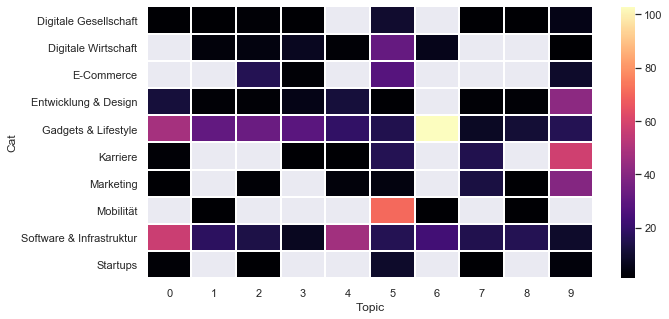

In [72]:
sns.set(rc={'figure.figsize':(10,5)})
ax = sns.heatmap(pivot_df, cmap='magma', linecolor='white', linewidth=1)
#fig = ax.get_figure()
#fig.savefig('plots/heatmap_t3n.png')

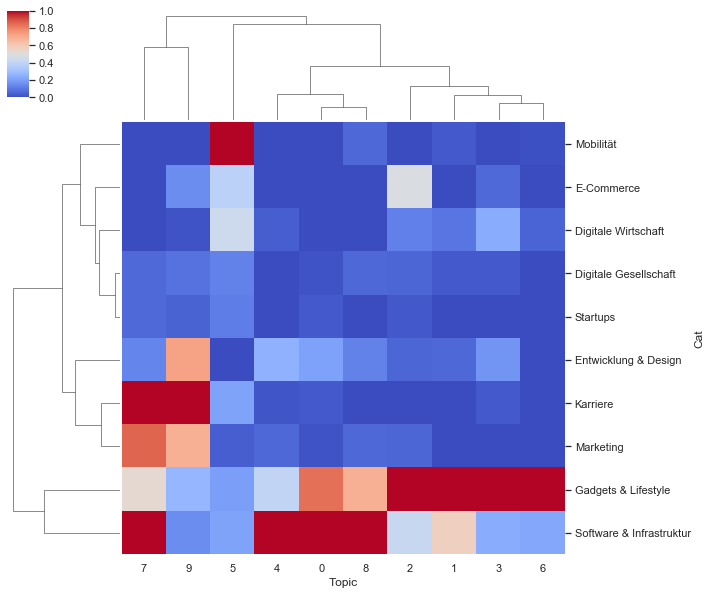

In [73]:
pivot_df.fillna(inplace=True, value=0)
ax = sns.clustermap(pivot_df, cmap='coolwarm', standard_scale=1)
#plt.savefig('plots/clustermap_t3n.png')